# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.
GPU нам пока не понадобится.

Основные ссылки:
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
https://pytorch.org/docs/stable/nn.html
https://pytorch.org/docs/stable/torchvision/index.html

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов SubsetRandomSampler и DataLoader.

DataLoader подгружает данные, предоставляемые классом Dataset, во время тренировки и группирует их в батчи. Он дает возможность указать Sampler, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

print("indices is\n", len(val_sampler))

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

indices is
 14651


В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем Flattener.

In [5]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:

nn_model - собственно, модель с нейросетью

loss - функцию ошибки, в нашем случае CrossEntropyLoss

optimizer - алгоритм оптимизации, в нашем случае просто SGD

In [7]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

# Тренируем!

Ниже приведена функция train_model, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию compute_accuracy, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [8]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        if not scheduler  is None:
            scheduler.step()
            print("step")
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0         
    for i_step, (x, y) in enumerate(val_loader):
        count = i_step
        predictions = nn_model(x)
        pred = torch.argmax(predictions, axis=1)
        correct_samples += torch.sum(pred == y)
        total_samples += y.shape[0]

    val_accuracy = float(correct_samples) / total_samples
    # print("val accuracy is ", val_accuracy)       
    return val_accuracy


    
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    raise Exception("Not implemented")
    
    return 0

# val_loader.
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.834957, Train accuracy: 0.407655, Val accuracy: 0.555866
Average loss: 1.460087, Train accuracy: 0.583831, Val accuracy: 0.602484
Average loss: 1.380018, Train accuracy: 0.619169, Val accuracy: 0.623848


# После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [40]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.169266, Train accuracy: 0.215183, Val accuracy: 0.252747
Average loss: 2.007896, Train accuracy: 0.275774, Val accuracy: 0.281073
Average loss: 1.854946, Train accuracy: 0.334130, Val accuracy: 0.370623
Average loss: 1.731816, Train accuracy: 0.406887, Val accuracy: 0.407617
Average loss: 1.682593, Train accuracy: 0.431731, Val accuracy: 0.423521


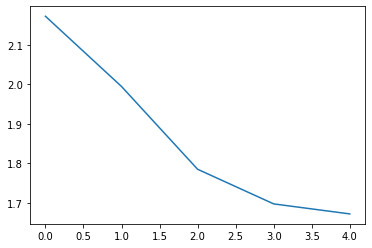

In [37]:
plt.plot(loss_history)
plt.show()


In [39]:

# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.063724, Train accuracy: 0.314609, Val accuracy: 0.421063
Average loss: 1.754835, Train accuracy: 0.463639, Val accuracy: 0.509522
Average loss: 1.619905, Train accuracy: 0.534297, Val accuracy: 0.566446
Average loss: 1.534069, Train accuracy: 0.575299, Val accuracy: 0.591086
Average loss: 1.473195, Train accuracy: 0.601679, Val accuracy: 0.613200


In [11]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma= 2)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

step
Average loss: 2.074605, Train accuracy: 0.305993, Val accuracy: 0.445908
step
Average loss: 1.759303, Train accuracy: 0.484677, Val accuracy: 0.533138
step
Average loss: 1.599192, Train accuracy: 0.566085, Val accuracy: 0.597024
step
Average loss: 1.481816, Train accuracy: 0.609579, Val accuracy: 0.632244
step
Average loss: 1.469575, Train accuracy: 0.609494, Val accuracy: 0.649375


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается. Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.
Чтобы это сделать мы приводим код SubsetSampler, который просто проходит по всем заданным индексам последовательно и составляет из них батчи.

Реализуйте функцию evaluate_model, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [14]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    val_sampler = SubsetSampler(indices)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=1,
                                         sampler=val_sampler)

    predictions = []
    ground_truth = []
    for i_step, (x, y) in enumerate(val_loader):
            pred = model(x)
            pred =  torch.argmax(pred, axis=1)
            predictions.append(pred.detach().numpy())
            ground_truth.append(y.detach().numpy())

    # predictions = np.array(predictions)
    # ground_truth = np.array(ground_truth)
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    # raise Exception("Not implemented")
    print('len pred ', len(predictions))
    print('len indices ', len(indices))
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
print("pred type is ", type(predictions[0]))
print("pred  is ", predictions[0])
print("gt  is ", gt[0])

assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

len pred  14651
len indices  14651
pred type is  <class 'numpy.ndarray'>
pred  is  [2]
gt  is  [3]


In [34]:
# count = 0
            # _, indices = torch.max(prediction, 1)
            # correct_samples += torch.sum(indices == y)
            # total_samples += y.shape[0]

correct_samples = 0
total_samples = 0         
for i_step, (x, y) in enumerate(val_loader):
    count = i_step
    predictions = nn_model(x)
    pred = torch.argmax(predictions, axis=1)
    correct_samples += torch.sum(pred == y)
    total_samples += y.shape[0]
    # print(y.shape)
    # print(i_step)

val_accuracy = float(correct_samples) / total_samples
print(val_accuracy)
# print(count)
# val_loader.dataset.data
# print(y.shape)
# print(data_train.data.shape)

# all_y = val_loader.dataset.labels
# all_X = val_loader.dataset.data
# # nn_model.eval() # Evaluation mode
# predictions = nn_model(all_X[0])
# print("pred shape ", all_X.shape)

0.6326530612244898
